# Setup

* Clone github repository

In [1]:
!git clone https://github.com/BeppeMaxCaru/AMD_DeepLearning.git

Cloning into 'AMD_DeepLearning'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 103 (delta 5), reused 3 (delta 0), pack-reused 86
Receiving objects: 100% (103/103), 697.41 KiB | 15.85 MiB/s, done.
Resolving deltas: 100% (30/30), done.


* Download and import libraries

In [2]:
!pip install kaggle
!pip install livelossplot

import zipfile
import json
import pandas as pd
import numpy as np
import random
from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 10.0 MB/s 
     |████████████████████████████████| 381 kB 40.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but y

* Extract hashtags to predict

In [3]:
hashtags_json = json.load(open('/content/AMD_DeepLearning/src/top_hashtags_index.json'))

hashtags_list = list(hashtags_json.items())
hashtags_list.sort(key = lambda pair: pair[1])
TOP_HASHTAGS = [elem[0] for elem in hashtags_list]

* Set Kaggle API Token

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

* Import dataset from Kaggle

In [5]:
!kaggle datasets download -d k4ggl3gpu/algorithmsformassivedataset20212022dataset

zipped_dataset = '/content/algorithmsformassivedataset20212022dataset.zip'

 98% 633M/647M [00:06<00:00, 117MB/s]
100% 647M/647M [00:06<00:00, 104MB/s]


* Unzip and check dataset

In [6]:
zf = zipfile.ZipFile(zipped_dataset)

#Check all files inside zip folder
print(zf.namelist())
#Open and read csv file
df_dataset = pd.read_csv(zf.open('dataset.csv'), header=None)
df_dataset = df_dataset.astype('string')
df_dataset = df_dataset.fillna('')

print(df_dataset.dtypes)
print(df_dataset.info())
print(df_dataset.sample(10))

['dataset.csv']
0    string
1    string
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26700388 entries, 0 to 26700387
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   0       string
 1   1       string
dtypes: string(2)
memory usage: 407.4 MB
None
                                                          0                  1
1866106   germany africa tell food syria invasion lebano...  0 1 3 31 43 63 65
16568838  truth patriot movement constitution neither co...                   
524261                         embassy performance appeared                  4
23406836  far massive 100km away rocked could explosion ...           0 1 5 73
9256733   plunge double border history 196km uppermost c...               1 10
6245545   obligated lifted famine man made imposed n dem...                 17
10841880  eight needs rising delivering growing one assi...                  0
14084163  least nuclear assurances close gave threat mem...               

# Configuration parameters

* Fine tune neural networks

In [7]:
#Slice of dataset to use
first_tweet = 5000000
last_tweet = 5500000

#Embedding neural network parameters
embedding_neural_network_vectorization_layer_output_tokens = 50
embedding_neural_network_words_dictionary_size = 10000
embedding_neural_network_words_embedding_dimensions = int(embedding_neural_network_words_dictionary_size ** 0.25)

#Embedding neural network to process input data

* Embedding neural network input layer

In [8]:
embedding_neural_network_input_layer = tf.keras.layers.InputLayer(
    input_shape=(1,1),
    dtype=tf.string
    )

* Embedding neural network text vectorization layer

In [9]:
embedding_neural_network_text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=embedding_neural_network_words_dictionary_size, #Limits learned vocabulary to top 10000 most frequent tokens
    standardize='lower_and_strip_punctuation', #All words become lowercase and punctuation is removed
    split='whitespace', #Splits input string into tokens using whitespace as delimiter
    output_mode='int', #Output encoding type
    output_sequence_length=embedding_neural_network_vectorization_layer_output_tokens #Number of output tokens
    )

embedding_neural_network_text_vectorization_layer.adapt(df_dataset.iloc[first_tweet:last_tweet, 0:1])

embedding_neural_network_vectorization_layer_vocabulary_lenght = len(embedding_neural_network_text_vectorization_layer.get_vocabulary())

* Embedding neural network embedding layer

In [10]:
embedding_neural_network_embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_neural_network_vectorization_layer_vocabulary_lenght,
    output_dim=embedding_neural_network_words_embedding_dimensions,
    input_length=embedding_neural_network_vectorization_layer_output_tokens
    )

* Embedding neural network flattening layer

In [11]:
embedding_neural_network_flattening_layer = tf.keras.layers.Flatten()

* Embedding neural network model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1, 50)            0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1, 50, 10)         100000    
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
Total params: 100,000
Trainable params: 100,000
Non-trainable params: 0
_________________________________________________________________


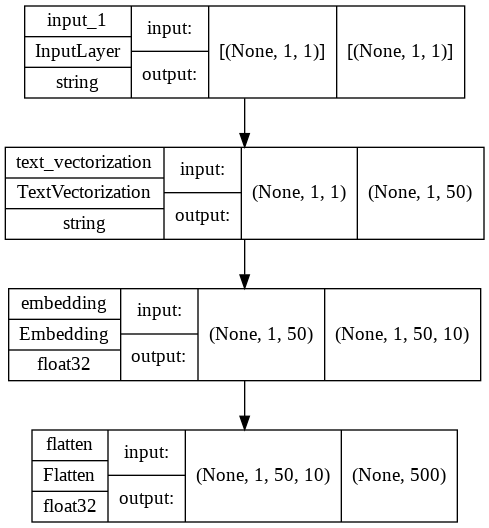

In [12]:
embedding_neural_network = tf.keras.Sequential([
                             embedding_neural_network_input_layer,
                             embedding_neural_network_text_vectorization_layer,
                             embedding_neural_network_embedding_layer,
                             embedding_neural_network_flattening_layer,
                             #tf.keras.layers.GlobalAveragePooling2D()
                             ])

embedding_neural_network.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy']
    )

embedding_neural_network.summary()

tf.keras.utils.plot_model(
    embedding_neural_network,
    to_file="Embedding neural network.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=True, 
    show_layer_activations=True
    )

* Embedding neural network output used as input for the forecasting neural network

In [13]:
forecasting_neural_network_input_data = embedding_neural_network.predict(df_dataset.iloc[first_tweet:last_tweet, 0:1])

# Expected output labels decompression

* Labels decompressing function

In [14]:
#Expand second column of dataset
def from_indices_to_boolean_vector(indices):
    indices = str(indices.values[0])
    pads = [0 for _ in range(len(TOP_HASHTAGS))]
    if not indices:
      return pads
    indices = [int(x) for x in indices.split(' ')]
    for index in indices:
      pads[index] = 1
    return pads

* Labels decompressed as expected output for the forecasting neural network

In [15]:
forecasting_neural_network_expected_output_labels = df_dataset.iloc[first_tweet:last_tweet, 1:2].apply(from_indices_to_boolean_vector, axis=1, result_type='expand')

# Forecasting neural network

* Forecasting neural network input and output shapes

In [16]:
forecasting_neural_network_input_shape = forecasting_neural_network_input_data.shape[1]
forecasting_neural_network_output_shape = len(TOP_HASHTAGS)

* Forecasting neural network input layer

In [17]:
forecasting_neural_network_input_layer = tf.keras.layers.InputLayer(
    input_shape=(forecasting_neural_network_input_shape),
    )

* Forecasting neural network model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               125250    
                                                                 
 dense_1 (Dense)             (None, 125)               31375     
                                                                 
 dense_2 (Dense)             (None, 100)               12600     
                                                                 
Total params: 169,225
Trainable params: 169,225
Non-trainable params: 0
_________________________________________________________________


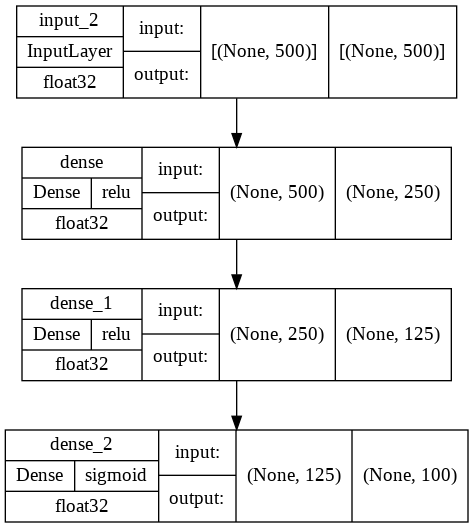

In [18]:
forecasting_neural_network = tf.keras.Sequential([
                          forecasting_neural_network_input_layer,
                          #tf.keras.layers.Dense(256, activation='relu'),   
                          #tf.keras.layers.Dense(128, activation='relu'),
                          tf.keras.layers.Dense((forecasting_neural_network_input_shape / 2), activation='relu'),
                          tf.keras.layers.Dense((forecasting_neural_network_input_shape / 4), activation='relu'),
                          tf.keras.layers.Dense(forecasting_neural_network_output_shape, activation='sigmoid')
                          ])

forecasting_neural_network.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    )

#forecasting_neural_network.build()

forecasting_neural_network.summary()

tf.keras.utils.plot_model(
    forecasting_neural_network,
    to_file="Forecasting neural network.png", 
    show_shapes=True, 
    show_dtype=True, 
    show_layer_names=True, 
    show_layer_activations=True
    )

# Training

* Split dataset into training and test data

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(forecasting_neural_network_input_data, forecasting_neural_network_expected_output_labels, test_size=0.3, random_state=random.randint(0, 100))

* Forecasting neural network training

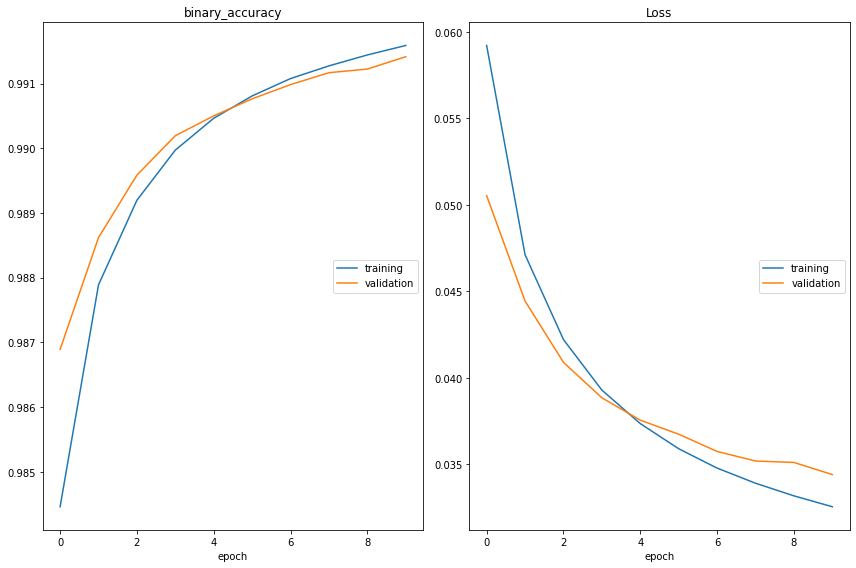

binary_accuracy
	training         	 (min:    0.984, max:    0.992, cur:    0.992)
	validation       	 (min:    0.987, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.033, max:    0.059, cur:    0.033)
	validation       	 (min:    0.034, max:    0.051, cur:    0.034)
8750/8750 [==============================] - 37s 4ms/step - loss: 0.0326 - binary_accuracy: 0.9916 - val_loss: 0.0344 - val_binary_accuracy: 0.9914


In [20]:
#Train model
forecasting_neural_network.fit(
    x=X_train, y=Y_train,
    validation_split=0.2,
    epochs=10,
    shuffle=True,
    callbacks=[PlotLossesKeras()]
    )

# Testing

* Forecasting neural network testing

In [21]:
#Test model
forecasting_neural_network.evaluate(
    x=X_test, y=Y_test,
    )

4688/4688 [==============================] - 9s 2ms/step - loss: 0.0342 - binary_accuracy: 0.9915


[0.0342094749212265, 0.9914880990982056]

# Playground

* Match hashtags with probabilities

In [102]:
with open("/content/AMD_DeepLearning/src/top_hashtags_reverse_index.json", "r") as input_file:
    top_tags = json.load(input_file)

def hashtags_with_probabilities(probabilities):
  tags = list()
  for index in range(len(probabilities[0])):
    tags.append((top_tags[str(index)], str(round(probabilities[0][index] * 100, 2))  + "%"))
  return tags

def hashtags_forecast(tweet):
  tweet_embeddings = embedding_neural_network.predict([tweet])
  probabilites = forecasting_neural_network.predict([tweet_embeddings])
  return hashtags_with_probabilities(probabilites)

def tweets_to_forecast(tweets_list):
  for tweet in tweets_list:
    tweet_result = hashtags_forecast(tweet)
    print(tweet + " : " + str(tweet_result) + "\n")

* Try it yourself!

In [101]:
#Type here a tweet of just words to receive its hashtags forecast
tweets_to_get_hashtags_forecast = ["Putin is the Russian president",
                                   "War in Ukraine",
                                   "Mariupol is under siege"]

tweets_to_forecast(tweets_to_get_hashtags_forecast)

Putin is the Russian president : [('ukraine', '32.47%'), ('russia', '22.85%'), ('standwithukraine', '14.24%'), ('putin', '15.91%'), ('russian', '8.26%'), ('mariupol', '2.3%'), ('ukrainerussiawar', '6.25%'), ('nato', '1.42%'), ('tigray', '2.47%'), ('ukrainewar', '1.24%'), ('kyiv', '3.86%'), ('ukrainian', '4.61%'), ('stoprussia', '4.45%'), ('news', '2.73%'), ('armukrainenow', '7.45%'), ('russiaukrainewar', '6.34%'), ('usa', '3.12%'), ('stopputin', '0.42%'), ('kharkiv', '1.51%'), ('slavaukraini', '1.48%'), ('bucha', '1.57%'), ('ukrainerussianwar', '2.57%'), ('biden', '2.55%'), ('ukraineunderattack', '0.74%'), ('business', '2.86%'), ('war', '0.93%'), ('russianukrainianwar', '3.34%'), ('stopputinnow', '2.86%'), ('azovstal', '0.27%'), ('eu', '0.61%'), ('ukraine️', '0.95%'), ('kherson', '4.61%'), ('anonymous', '0.49%'), ('standwithukraine️', '0.75%'), ('russianwarcrimes', '0.77%'), ('china', '1.09%'), ('us', '0.25%'), ('tigraygenocide', '0.38%'), ('russians', '0.06%'), ('zelensky', '3.7%'), (